In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。<br>
ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。<br>
シグモイド関数は以下の式で表されます。<br>

$$g(z) = \frac{1}{1+e^{−z}}.$$

線形回帰の仮定関数は次の式でした。<br>

$$h_\theta(x) = \theta^T \cdot x.$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。<br>

$$h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.$$

𝑥 : 特徴量ベクトル<br>
𝜃 : パラメータ（重み）ベクトル

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。<br>
以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。<br>

$$ \theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1 $$

𝛼 : 学習率<br>
𝑖 : サンプルのインデックス<br>
𝑗 : 特徴量のインデックス<br>
𝑚 : 入力されるデータの数<br>
ℎ𝜃() : 仮定関数<br>
𝑥 : 特徴量ベクトル<br>
𝜃 : パラメータ（重み）ベクトル<br>
𝑥(𝑖) : i番目のサンプルの特徴量ベクトル<br>
𝑦(𝑖) : i番目のサンプルの正解ラベル<br>
𝜃𝑗 : j番目のパラメータ（重み）<br>
λ : 正則化パラメータ<br>

# 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。<br>
仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

# 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。<br>
そして、これをself.loss, self.val_lossに記録するようにしてください。<br>
なお、この数式には正則化項が含まれています。<br>

$$ J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\ $$

$m$ : 入力されるデータの数<br>
$h_\theta()$ : 仮定関数<br>
$x$ : 特徴量ベクトル<br>
$\theta$ : パラメータ（重み）ベクトル<br>
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル<br>
$y^{(i)}$ : i番目のサンプルの正解ラベル<br>
$\theta_j$ : j番目のパラメータ（重み）<br>
$n$ : 特徴量の数<br>
$λ$ : 正則化パラメータ<br>

# 【問題】１〜４の回答をScratchLogisticRegressionクラスに実装

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    c : float   #新たに追加
      L2正則化定数（λ）  
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, c, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.c = c
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X_in, y, X_val_in=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値    
        """
                
        #訓練データの処理
        w_up_array = [] #更新された重みを格納するリスト
        for i in range(self.iter):
            y_pred_proba, y_pred, X, w = self._logi_linear_hypothesis(X_in, w_up_array) #仮定関数
            error = y_pred_proba - y.reshape(-1, 1) #誤差の算出
            w_update = self._gradient_descent(X, w, error) #重みの更新
            w_up_array.append([a for a in w_update]) #更新された重みをリストへ格納
            self.loss[i] = self._cost_function(y_pred_proba, y, w)  #目的関数       
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.loss)
        
        #学習済みのパラメータ（重み）
        self.coef_ = np.array([w_up_array]).flatten()[-(X.shape[1]):].reshape(X.shape[1], 1)     
        
        #検証データの処理
        if X_val_in is None and y_val is None:
            pass
        else:
            w_up_array_val = [] #更新された重みを格納するリスト
            for i in range(self.iter):
                y_pred_val_proba, y_pred_val, X_val, w_val = self._logi_linear_hypothesis(X_val_in, w_up_array_val) #仮定関数
                error_val = y_pred_val_proba - y_val.reshape(-1, 1) #誤差の算出
                w_update_val = self._gradient_descent(X_val, w_val, error_val) #重みの更新
                w_up_array_val.append([a for a in w_update_val]) #更新された重みをリストへ格納
                self.val_loss[i] = self._cost_function(y_pred_val_proba, y_val, w_val)  #目的関数       
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print(self.val_loss)
        
        pass
    
    #【問題1】のロジスティック回帰の仮定関数を実装
    def _logi_linear_hypothesis(self, X, w_up_array):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """    
        if self.bias:
            n_samples = X.shape[0]
            add_1 = np.array([[1] * n_samples]).T #バイアス用に１の列を作成
            X = np.hstack([add_1, X]) #Xに１の列を追加
        else:
            pass
            
        if type(w_up_array) is np.ndarray:
            w = w_up_array #最終的に更新された重みを受け取る時の処理（検証データ用）
        elif len(w_up_array) > 0:
            w = np.array([w_up_array]).flatten()[-(X.shape[1]):].reshape(X.shape[1], 1) #更新された重みを受け取った時用の処理
        else:
            w = np.random.random((X.shape[1], 1)) #ランダムでパラメータを設定（重みの初期値を設定する時の処理）
        
        #線形回帰の仮定関数
        y_hyp = X @ w #wは、w.shape = (X.shape[1], 1)  の２次元
        
        #ロジスティック回帰の仮定関数
        y_pred_proba = 1 / (1 + np.exp(-y_hyp))
        y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
        
        pass
        return y_pred_proba, y_pred, X, w

    def _gradient_descent(self, X, w, error):
        """
        最急降下法により、最適なパラメータwを学習させる

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        error : 予測値と目的変数との誤差
        
        w : パラメータ（重み）

        """
        j_mean_array = np.array([])
        for j in range(X.shape[1]):   #X_add_1の列番号を抽出
            #抽出した列の要素を一つずつ処理し、列の平均を算出
            # j = 0 は正則化項無し
            if X.shape[1] == 0:
                j_mean = sum(error[i] * X[i, j] for i in range(X.shape[0])) / X.shape[0]
                j_mean_array = np.append(j_mean_array,  j_mean)
            # j = 0 以外は正則化項有り
            else:
                j_mean = sum(error[i] * X[i, j] for i in range(X.shape[0])) / X.shape[0]
                j_mean_add_regu = j_mean + (self.c / X.shape[0]) * w[j]
                j_mean_array = np.append(j_mean_array,  j_mean_add_regu)
       
        w_update = (w.T - self.lr * j_mean_array).T #重みの更新
        
        pass
        return w_update #更新した重みをリターン
    
    #目的関数
    def _cost_function(self, y_pred_proba, y, w):
        cost_list = []
        for i in range(y.shape[0]):
            cost_pre = (-y[i]*np.log(y_pred_proba[i])) - (1 - y[i])*np.log(1 - y_pred_proba[i])
            cost_list.append(cost_pre)
        cost = sum(np.nan_to_num(cost_list)) / y.shape[0] + self.c * sum(w[i]**2 for i in range(w.shape[0])) / (2*y.shape[0])

        return cost
        
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        X_val = X
        w = self.coef_
        y_pred_val_proba, y_pred_val, X_val, w = self._logi_linear_hypothesis(X_val, w) #仮定関数より、学習された重みを使って確率を推定
        
        pass
        return y_pred_val
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        X_val = X
        w = self.coef_
        y_pred_val_proba, y_pred_val, X_val, w = self._logi_linear_hypothesis(X_val, w) #仮定関数より、学習された重みを使って確率を推定
        
        pass
        return y_pred_val_proba

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [4]:
#irisデータセットを取得
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names) #説明変数
y = pd.DataFrame(iris.target, columns=["Species"]) #目的変数
df = pd.concat([X, y], axis=1)#説明変数と目的変数を結合
df = df.replace({"Species": dict(enumerate(iris.target_names))}) #Speciesの要素をtarget_namesに変更
df_versicolor_virginica = df.query('Species == ["versicolor",  "virginica"]') #versicolorとvirginicaを抽出
df_versicolor_virginica = df_versicolor_virginica.replace({"Species": {'versicolor': 0,  'virginica': 1}}) #目的関数の計算に合わせ、クラスを0,1に変更

#ndarrayに変換
X_data = np.array(df_versicolor_virginica.iloc[:, :4])
y_data = np.array(df_versicolor_virginica["Species"])

# 訓練データと検証データの分割。訓練データ75%、検証データ25%として分割する。
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.75, random_state=123)
    
#標準化
scaler = StandardScaler()
scaler.fit(X_train) #訓練用のデータでfit
X_train_std = scaler.transform(X_train) #訓練用データをtransform
X_test_std = scaler.transform(X_test) #検証用データをtransform

In [5]:
#今回スクラッチしたモデル
slor = ScratchLogisticRegression(num_iter=1000, lr=10**-1, c=1.0, bias=True, verbose=None)
slor.fit(X_train_std, y_train, X_test_std, y_test) #学習
y_pred_proba = slor.predict_proba(X_test_std) #推定（確率）
y_pred = slor.predict(X_test_std)#推定（クラス）
print(slor.coef_) #学習された重み
print(y_pred_proba)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[[ 0.05552386]
 [ 0.08112569]
 [-0.5704229 ]
 [ 2.15988613]
 [ 1.96731085]]
[[0.06397186]
 [0.9865744 ]
 [0.98530993]
 [0.11140806]
 [0.89850939]
 [0.08079932]
 [0.05348276]
 [0.99682046]
 [0.97728972]
 [0.16944238]
 [0.05821753]
 [0.96159236]
 [0.57011259]
 [0.78989883]
 [0.03018822]
 [0.01401302]
 [0.5447507 ]
 [0.0141081 ]
 [0.35752367]
 [0.94061423]
 [0.07784445]
 [0.47834185]
 [0.00795417]
 [0.0015476 ]
 [0.0035384 ]]
[[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]
正解率：0.92
適合率：0.87
再現率：1.00
F値：0.93
混同行列：
[[13  0]
 [ 2 10]]
classification_report：
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.83      0.91        12

    accuracy                           0.92        25
   macro avg       0.93      0.92      0.92        25
weighted avg       0.93      0.92      0.92        25



In [6]:
# LogisticRegressionにて確認
lor = LogisticRegression()
lor.fit(X_train_std, y_train) #学習
y_pred_proba = lor.predict_proba(X_test_std) #推定（確率）
y_pred = lor.predict(X_test_std) #推定（クラス）
print(lor.coef_) #学習された重み
print(y_pred_proba)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[[ 0.06062076 -0.57416656  2.19257653  1.97464456]]
[[0.93741817 0.06258183]
 [0.01311518 0.98688482]
 [0.01415158 0.98584842]
 [0.88913795 0.11086205]
 [0.09824808 0.90175192]
 [0.92165094 0.07834906]
 [0.94645284 0.05354716]
 [0.00300724 0.99699276]
 [0.02253047 0.97746953]
 [0.83276861 0.16723139]
 [0.94205441 0.05794559]
 [0.03754668 0.96245332]
 [0.42835303 0.57164697]
 [0.20884144 0.79115856]
 [0.97064628 0.02935372]
 [0.98626719 0.01373281]
 [0.4525488  0.5474512 ]
 [0.98607607 0.01392393]
 [0.63416213 0.36583787]
 [0.05842116 0.94157884]
 [0.92283095 0.07716905]
 [0.51913801 0.48086199]
 [0.99219312 0.00780688]
 [0.9985132  0.0014868 ]
 [0.99654553 0.00345447]]
[0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0]
正解率：0.92
適合率：0.87
再現率：1.00
F値：0.93
混同行列：
[[13  0]
 [ 2 10]]
classification_report：
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      0.83      0.91        12

    accuracy           

In [7]:
# SGDClassifier(loss="log")にて確認
sgdc = SGDClassifier(loss="log")
sgdc.fit(X_train_std, y_train) #学習
y_pred_proba = sgdc.predict_proba(X_test_std) #推定（確率）
y_pred = sgdc.predict(X_test_std) #推定（クラス）
print(sgdc.coef_) #学習された重み
print(y_pred_proba)
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[[-0.78482305 -3.04993314 23.07008337 11.67286265]]
[[1.00000000e+00 4.03929165e-10]
 [5.77315973e-15 1.00000000e+00]
 [1.90958360e-14 1.00000000e+00]
 [9.99999986e-01 1.36912531e-08]
 [1.59982393e-06 9.99998400e-01]
 [9.99999996e-01 3.83283222e-09]
 [1.00000000e+00 1.92336880e-10]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [9.99999710e-01 2.89880495e-07]
 [9.99999998e-01 1.72361028e-09]
 [1.65279346e-10 1.00000000e+00]
 [7.25005248e-01 2.74994752e-01]
 [1.71220027e-04 9.99828780e-01]
 [1.00000000e+00 1.48393269e-13]
 [1.00000000e+00 8.67075545e-17]
 [4.95634770e-01 5.04365230e-01]
 [1.00000000e+00 6.59053960e-16]
 [9.99498643e-01 5.01357207e-04]
 [2.42361686e-12 1.00000000e+00]
 [9.99999998e-01 2.17166216e-09]
 [9.29564505e-01 7.04354952e-02]
 [1.00000000e+00 1.14462463e-18]
 [1.00000000e+00 4.89968265e-25]
 [1.00000000e+00 8.90930626e-22]]
[0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0]
正解率：0.88
適合率：0.81
再現率：1.00
F値：0.90
混同行列：
[[13  0]
 [ 3  9]]
classifica

### LogisticRegressionとの比較では、正解率・適合率・再現率・F値全て同じ結果となった。SGDClassifier(loss="log")との比較では、再現率以外は異なる結果となった。パラメータ設定等の違いも有ると思われる為、詳細について理解を深めていく。

# 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

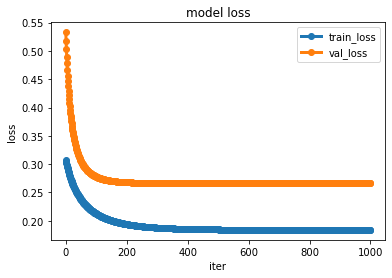

In [8]:
plt.title("model loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.plot(slor.loss, label="train_loss", marker="o", linewidth=3)
plt.plot(slor.val_loss, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

### 回数を重ねるごとに損失が低下しており、iter=1000のあたりでtrain_loss, val_loss共にサチュレートしていると思われる。

# 【問題7】決定領域の可視化
決定領域を可視化してください。

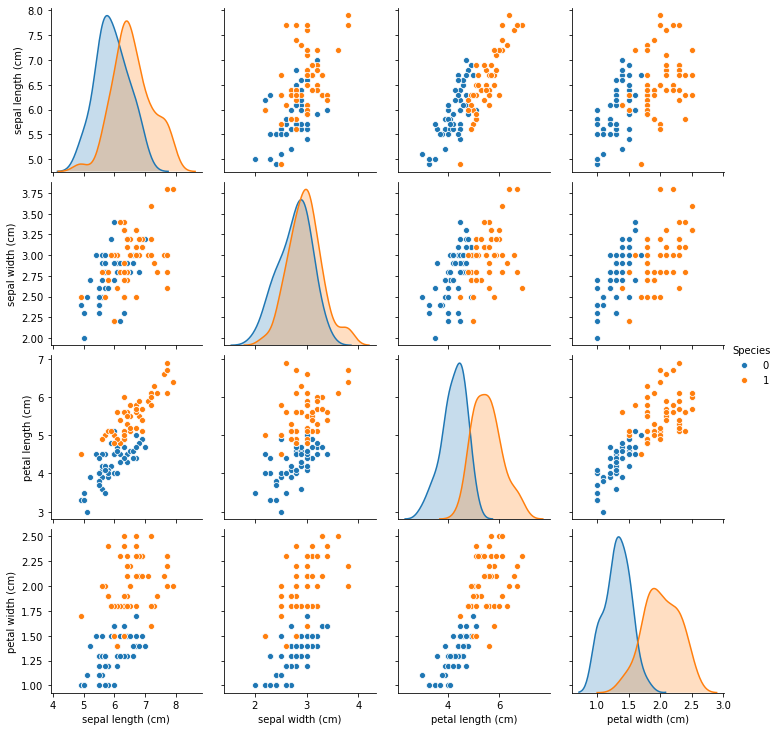

In [9]:
import seaborn as sns

sns.pairplot(df_versicolor_virginica, hue='Species')

### ４×３÷２＝６種類の決定領域を描画する。

In [10]:
#決定領域可視化の関数
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, target_names=["versicolor : 0", "virginica : 1"], step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel'):
    
    # 訓練データと検証データの分割。訓練データ75%、検証データ25%として分割する。
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=123)

    #標準化
    scaler = StandardScaler()
    scaler.fit(X_train) #訓練用のデータでfit
    X_train_std = scaler.transform(X_train) #訓練用データをtransform
    X_test_std = scaler.transform(X_test) #検証用データをtransform

    #今回スクラッチしたロジスティック回帰モデル
    slor = ScratchLogisticRegression(num_iter=1000, lr=10**-1, c=1.0, bias=True, verbose=None)
    slor.fit(X_train_std, y_train, X_test_std, y_test) #学習

    X = X_test_std
    y = y_test
    clf = slor
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = clf.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show() 

### sepal length × sepal width

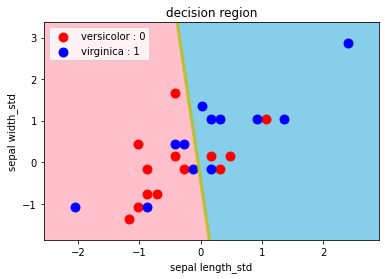

In [11]:
X = np.array(df_versicolor_virginica.iloc[:, :2])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='sepal length_std', ylabel='sepal width_std')

### sepal length × petal length

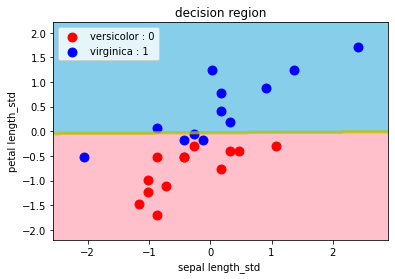

In [12]:
X = np.array(df_versicolor_virginica.iloc[:, [0, 2]])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='sepal length_std ', ylabel='petal length_std')

### sepal length × petal width

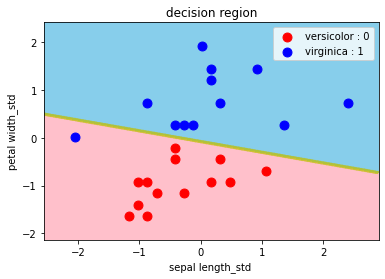

In [13]:
X = np.array(df_versicolor_virginica.iloc[:, [0, 3]])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='sepal length_std ', ylabel='petal width_std')

### sepal width × petal length

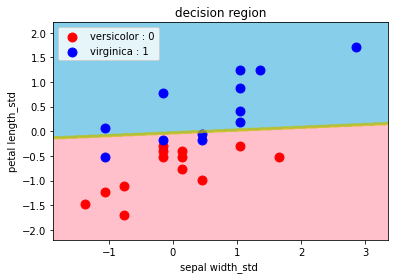

In [14]:
X = np.array(df_versicolor_virginica.iloc[:, [1, 2]])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='sepal width_std ', ylabel='petal length_std')

### sepal width × petal width

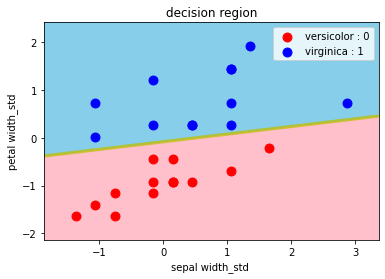

In [15]:
X = np.array(df_versicolor_virginica.iloc[:, [1, 3]])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='sepal width_std ', ylabel='petal width_std')

### petal length × petal width

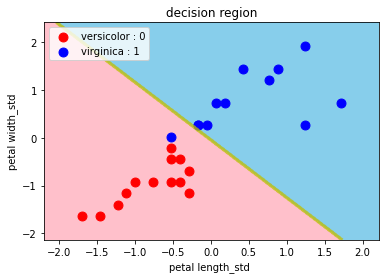

In [16]:
X = np.array(df_versicolor_virginica.iloc[:, [2, 3]])   #説明変数２つを抽出
y = np.array(df_versicolor_virginica["Species"])

decision_region(X, y, xlabel='petal length_std ', ylabel='petal width_std')

# 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [17]:
print(slor.coef_) #学習された重み

[[ 0.05552386]
 [ 0.08112569]
 [-0.5704229 ]
 [ 2.15988613]
 [ 1.96731085]]


### pickleモジュール

In [18]:
import pathlib
import os
import pickle

#ファイル作成
weight = pathlib.Path("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint")
weight.touch()

#ファイルへ書き込み
with open('weight', 'wb') as logi:
    pickle.dump(slor.coef_, logi)

#ファイル読み込み
with open('weight', 'rb') as logi:
    logi_weight = pickle.load(logi)
print(logi_weight)

[[ 0.05552386]
 [ 0.08112569]
 [-0.5704229 ]
 [ 2.15988613]
 [ 1.96731085]]


### NumPyのnp.savez

In [19]:
np.save("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint", slor.coef_)   #ファイル作成、書き込み
np.load("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint.npy")   #ファイル読み込み

array([[ 0.05552386],
       [ 0.08112569],
       [-0.5704229 ],
       [ 2.15988613],
       [ 1.96731085]])

In [20]:
np.savez("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint", slor.coef_)   #ファイル作成、書き込み
np.load("/Users/takahashihideyuki/dive/diveintocode-ml/Sprint.npy")   #ファイル読み込み

array([[ 0.05552386],
       [ 0.08112569],
       [-0.5704229 ],
       [ 2.15988613],
       [ 1.96731085]])